In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
from IPython.display import Image,display
import os

%matplotlib inline


2025-06-06 12:26:58.067109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749205618.386397  439517 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749205618.464542  439517 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749205618.843427  439517 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749205618.843527  439517 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1749205618.843530  439517 computation_placer.cc:177] computation placer alr

In [2]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
import os
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

dataset_path = './dataset/RealWaste'
img_size = (224, 224)
batch_size = 32
train_split = 0.8  

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            
    layers.RandomRotation(0.1),                 
    layers.RandomZoom(0.1),                    
    layers.RandomTranslation(0.1, 0.1),        
    layers.RandomContrast(0.1),                
])

full_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    color_mode="rgb"
)

dataset_size = tf.data.experimental.cardinality(full_dataset).numpy()
train_size = int(train_split * dataset_size)

train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)

augmented_and_preprocessed_train = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE
).map(
    lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE
).prefetch(tf.data.AUTOTUNE)

train_dataset = augmented_and_preprocessed_train
test_dataset = test_dataset.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

class_names = full_dataset.class_names
num_classes = len(class_names)

print("Liczba klas:", num_classes)
print("Nazwy klas:", class_names)


I0000 00:00:1749205648.757420  439517 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4084 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660, pci bus id: 0000:09:00.0, compute capability: 7.5


Found 4752 files belonging to 9 classes.
Liczba klas: 9
Nazwy klas: ['cardboard', 'glass', 'metal', 'organics', 'paper', 'plastic', 'textile', 'trash', 'vegetation']


Found 4752 files belonging to 9 classes.


2025-06-06 12:27:37.226210: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


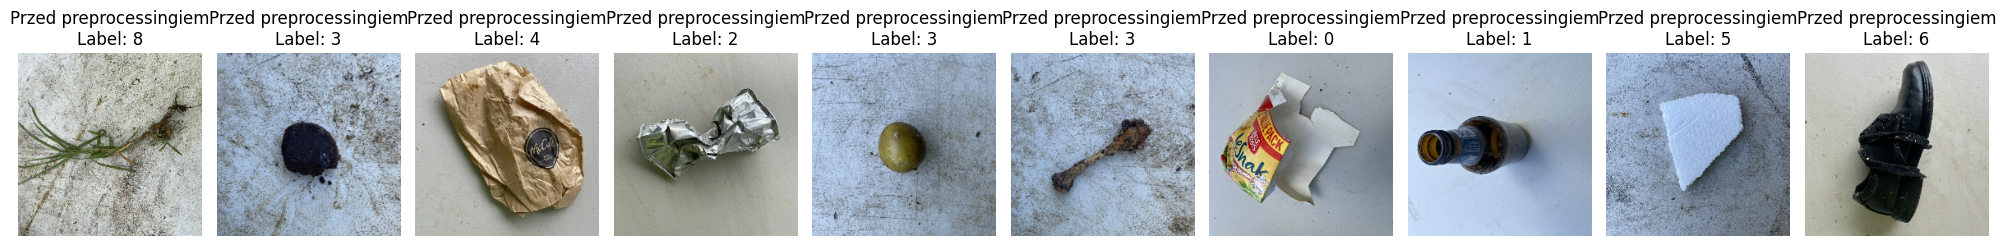

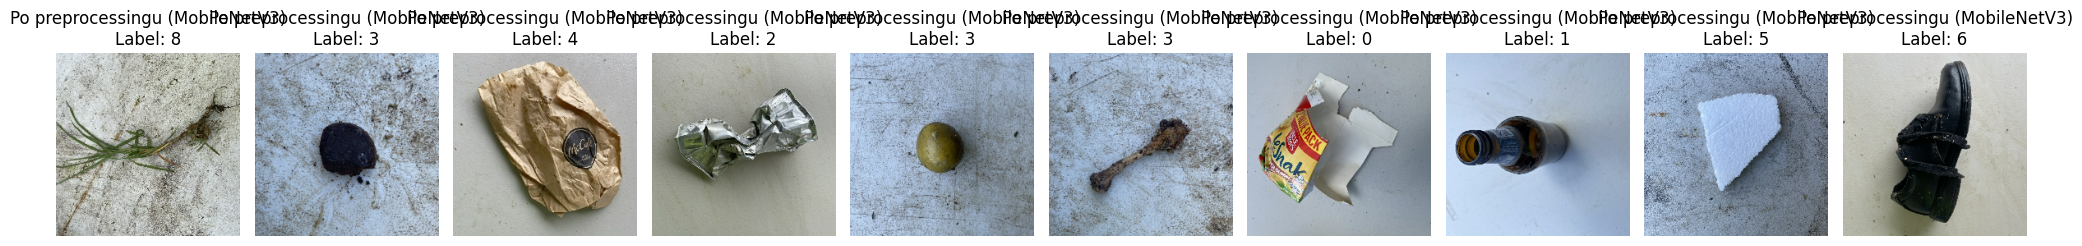

In [4]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

raw_dataset = image_dataset_from_directory(
    dataset_path,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size,
    color_mode="rgb"
)

for images, labels in raw_dataset.take(1):
    raw_images = images
    raw_labels = labels

processed_images = preprocess_input(tf.identity(raw_images))

def show_images(images, title, labels, n=10):
    plt.figure(figsize=(20, 4))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        img = images[i].numpy()
        if img.shape[-1] == 3:
            img = (img - img.min()) / (img.max() - img.min())  # skalowanie do [0,1]
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{title}\nLabel: {labels[i].numpy()}")
    plt.tight_layout()
    plt.show()

show_images(raw_images, "Przed preprocessingiem", raw_labels)
show_images(processed_images, "Po preprocessingu (MobileNetV3)", raw_labels)


2025-06-06 12:27:45.456368: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


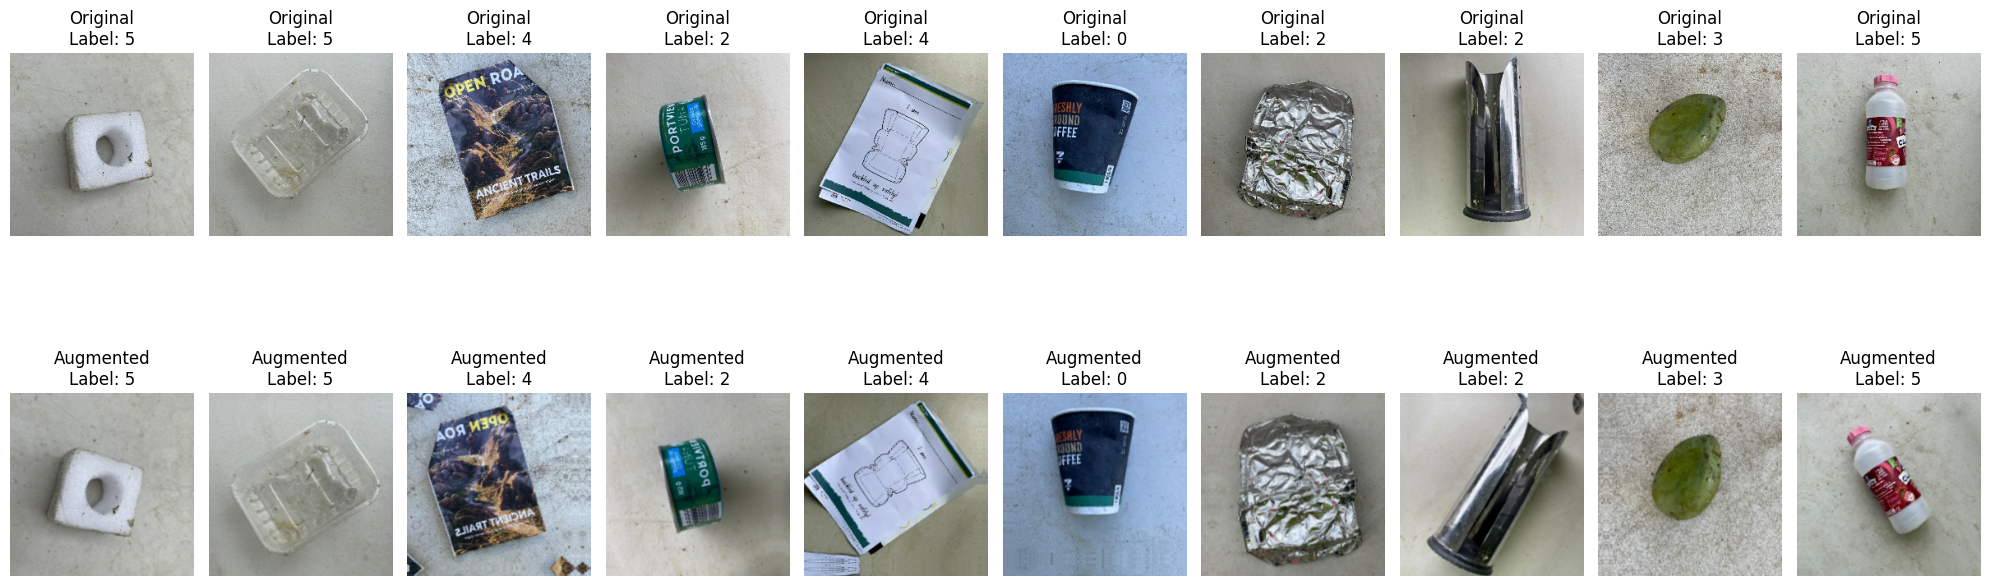

In [5]:
for images, labels in raw_dataset.take(1):
    raw_images = images
    raw_labels = labels
    augmented_images = data_augmentation(images, training=True)

def show_image_pairs(raw_imgs, aug_imgs, labels, n=10):
    plt.figure(figsize=(20, 8))
    for i in range(n):
        ax = plt.subplot(2, n, i + 1)
        raw_img = raw_imgs[i].numpy() / 255.0
        plt.imshow(raw_img)
        plt.title(f"Original\nLabel: {labels[i].numpy()}")
        plt.axis("off")

        ax = plt.subplot(2, n, n + i + 1)
        aug_img = aug_imgs[i].numpy() / 255.0
        plt.imshow(aug_img)
        plt.title(f"Augmented\nLabel: {labels[i].numpy()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_image_pairs(raw_images, augmented_images, raw_labels, n=10)

In [6]:
def count_images_per_class(directory):
    class_counts = {}
    for class_name in sorted(os.listdir(directory)):
        class_dir = os.path.join(directory, class_name)
        if os.path.isdir(class_dir):
            count = len([
                f for f in os.listdir(class_dir)
                if os.path.isfile(os.path.join(class_dir, f))
            ])
            class_counts[class_name] = count
    return class_counts

class_counts = count_images_per_class(dataset_path)
total = sum(class_counts.values())

print(f"Total images: {total}\n")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")


Total images: 4752

cardboard: 461
glass: 420
metal: 790
organics: 411
paper: 500
plastic: 921
textile: 318
trash: 495
vegetation: 436


In [7]:
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input

base_model = tf.keras.applications.MobileNetV3Large(input_shape=img_size + (3,), include_top=False, weights='imagenet')
base_model.trainable = False
fine_tune_at = 100

for layer in base_model.layers[fine_tune_at:]:
    layer.trainable = True

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(200, activation='relu'),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(7, activation='relu'),
        
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam',
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 200)            │       192,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        20,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 50)             │         5,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 7)              │           182 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │            72 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,215,231 (12.27 MB)

 Trainable params: 3,030,879 (11.56 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=200,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)]
)

Epoch 1/200


I0000 00:00:1749205719.020132  439972 service.cc:152] XLA service 0x63319dc12f80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749205719.020559  439972 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1660, Compute Capability 7.5
2025-06-06 12:28:40.189305: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1749205727.320844  439972 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1749205776.918247  439972 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


119/119 ━━━━━━━━━━━━━━━━━━━━ 166s 521ms/step - accuracy: 0.2452 - loss: 1.9383 - val_accuracy: 0.3411 - val_loss: 88.9122
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 30s 230ms/step - accuracy: 0.5485 - loss: 1.3353 - val_accuracy: 0.4354 - val_loss: 146.2894
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 27s 215ms/step - accuracy: 0.6720 - loss: 1.1236 - val_accuracy: 0.1727 - val_loss: 526.1086
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 199ms/step - accuracy: 0.7598 - loss: 0.8420 - val_accuracy: 0.4248 - val_loss: 25.2258
Epoch 5/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 24s 196ms/step - accuracy: 0.8189 - loss: 0.6842 - val_accuracy: 0.3506 - val_loss: 74.9138
Epoch 6/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 206ms/step - accuracy: 0.8435 - loss: 0.5884 - val_accuracy: 0.3199 - val_loss: 41.5120
Epoch 7/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 26s 202ms/step - accuracy: 0.8567 - loss: 0.5309 - val_accuracy: 0.3739 - val_loss: 29.4443
Epoch 8/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.8816 - l

In [9]:
from datetime import datetime

results_dir = './results/'

def get_data_folder():
    now = datetime.now()
    folder_name = now.strftime("%Y_%m_%d:%H-%M-%S")
    folder_path = os.path.join(results_dir, folder_name)
    os.makedirs(folder_path, exist_ok=True)
    return folder_path

data_folder = get_data_folder()

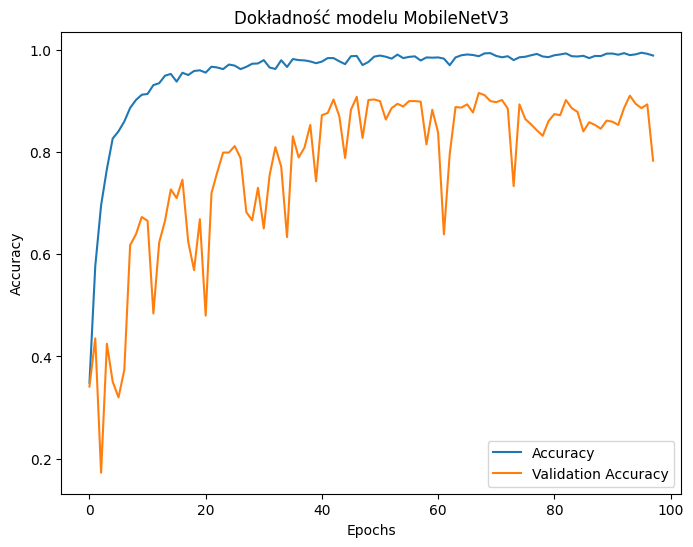

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(8, 6))
plt.plot(acc, label='Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Dokładność modelu MobileNetV3')

accuracy_path = os.path.join(data_folder, 'accuracy.png')
plt.savefig(accuracy_path)
plt.show()
plt.close()

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114m

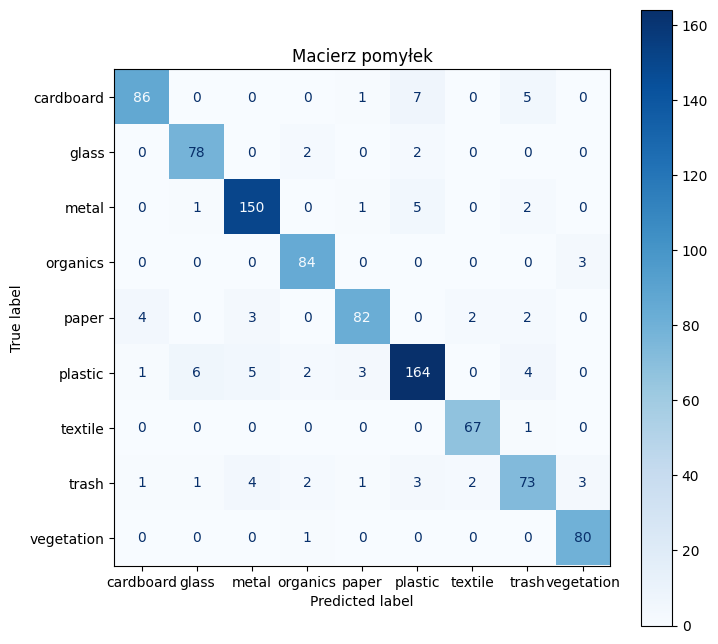

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

all_labels = []
all_pred_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    all_labels.append(labels.numpy())
    all_pred_labels.append(pred_labels)

all_labels_np = np.concatenate(all_labels, axis=0)
all_pred_labels_np = np.concatenate(all_pred_labels, axis=0)

classes = class_names

cm = confusion_matrix(all_labels_np, all_pred_labels_np)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, colorbar=True)
plt.title("Macierz pomyłek")

cm_path = os.path.join(data_folder, 'confusion_matrix.png')
plt.savefig(cm_path)
plt.show()
plt.close()

In [12]:
model.save('model.keras')

In [13]:
import json


def save_model_summary_markdown(model, filepath):
    lines = []
    model.summary(print_fn=lambda x: lines.append(x))

    with open(filepath, 'w') as f:
        f.write("\n".join(lines))


def dataset_summary_markdown(filepath):
    train_total = sum(train_counts.values())
    test_total = sum(test_counts.values())
    grand_total = train_total + test_total

    with open(filepath, 'w') as f:
        f.write("# Dataset info\n\n")
        f.write(f"- Dataset path: `{dataset_path}`\n")
        f.write(f"- Percent of dataset used for training: {train_dataset_percent*100:.1f}%\n")
        f.write(f"- Number of classes: {num_classes}\n")
        f.write(f"- Classes: {class_names}\n")
        f.write(f"- Batch size: {batch_size}\n")
        f.write(f"- Image size: {img_size}\n")
        f.write(f"- Number of images: {train_total + test_total }\n")

        f.write("#\n\n")

        f.write(f"### Train ({train_total}):\n")
        for cls in class_names:
            f.write(f"- {cls}: {train_counts.get(cls, 0)}\n")

        f.write(f"### Test ({test_total }):\n")
        for cls in class_names:
          f.write(f"- {cls}: {test_counts.get(cls, 0)}\n")


def training_model_summary_markdown(filepath):
    with open(filepath, 'w') as f:
        f.write("# Training info\n\n")
        f.write(f"- Number of epochs: {len(history.history['loss'])}\n")
        f.write(f"- Optimizer: Adam (default)\n")
        f.write(f"- Loss function: sparse_categorical_crossentropy\n")
        f.write(f"- Metrics: accuracy\n")

save_model_summary_markdown(model, os.path.join(data_folder, 'model.md'))
dataset_summary_markdown(os.path.join(data_folder, 'dataset.md'))
training_model_summary_markdown(os.path.join(data_folder, 'training.md'))

NameError: name 'train_counts' is not defined